# 3.2 簡易デモザイク処理

## この節について

この節では、RAWデータの簡易でモザイク処理を行い、画像をフルカラーで表示してみます。

## 準備

まず前節で行ったライブラリーのインストールと、モジュールのインポート、画像のダウンロード、及びRAW画像の読み込みを行います。
内容については前節を参照ください。

In [1]:
# rawpyとimageioのインストール
!pip install rawpy
!pip install imageio

# rawpy, imageio, numpuy, pyplot, imshowのインポート
import rawpy, imageio
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

# 画像をダウンロードします。
!wget https://raw.githubusercontent.com/moizumi99/raw_process/master/sample.ARW

# 自分で撮影した画像を使用する場合は以下のコメントを取り除きアップロードします。
# from google.colab import files
# uploaded = files.upload()

# RAWファイルの名前。
# アップロードしたファイルを使う場合はその名前に変更。
raw_file  = "sample.ARW"
raw = rawpy.imread(raw_file)
raw_array = raw.raw_image
h, w = raw.sizes.raw_height, raw.sizes.raw_width
raw_array = raw_array.reshape((h, w))

--2019-01-26 15:56:51--  https://raw.githubusercontent.com/moizumi99/raw_process/master/sample.ARW
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.188.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.188.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 24746752 (24M) [application/octet-stream]
Saving to: ‘sample.ARW.1’

sample.ARW.1        100%[===================>]  23.60M  52.3MB/s    in 0.5s    

2019-01-26 15:56:51 (52.3 MB/s) - ‘sample.ARW.1’ saved [24746752/24746752]



## RAW画像の確認

読み込んだRAW画像を表示してみます。

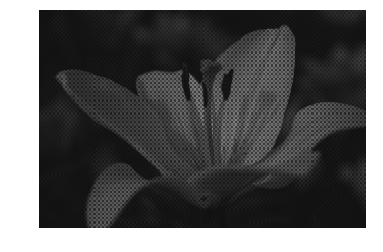

In [2]:
# raw_arrayの中のデータをグレースケールで表示します。
imshow(raw_array, cmap='gray')
# 軸を非表示にします。
plt.axis('off')
# 実際に表示します。
plt.show()

拡大して見てみましょう。

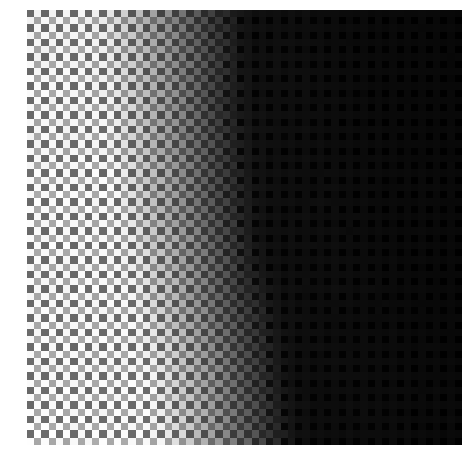

In [3]:
# pyplotのコマンドfigure()を使って表示サイズを調整.
# ここではfigsize=(8, 8)で、8inch x 8inchを指定（ただし実際の表示サイズはディスプレイ解像度に依存） 
plt.figure(figsize=(8, 8))

# RAW画像の中から(1310, 2620)から60x60の領域を表示。
imshow(raw_array[1310:1370, 2620:2680], cmap='gray')
# 軸非表示
plt.axis('off')
# 画像表示
plt.show()

明るいところが緑、暗いところが赤や青の画素のはずです。

## 疑似カラー化

Bayerの赤の部分を赤、青を青、緑を緑で表示してみましょう。

まず、RAW画像の配列を確認しておきます。

In [4]:
print(raw.raw_pattern)

[[0 1]
 [3 2]]


raw_patternはrawpyのアトリビュートで、Bayer配列の2x2行列を示します。

ここで、各番号と色の関係は以下のようになっています。カッコ内は略称です

| 番号 | 色 |
|--------|-----|
| 0 | 赤 (R) |
| 1 | 緑 (Gr) |
| 2 | 青 (B) |
| 3 | 緑 (Gb) |

ここで緑にGrとGbがあるのは、赤の行の緑と青の行の緑を区別するためです。カメラ画像処理では両者を区別することが多々あり、両者をGrとGbと表す事があります。

両者を区別する必要が無い場合はどちらもGであらわします。


この対応関係を考えると、この画像の各画素の色は、左上から

赤　緑

緑　青

のように並んでいることがわかります。これを図示するとこうなります。


![この画像のBayer配列](https://github.com/moizumi99/camera_raw_processing/raw/master/fig3_1_1.png)

では、これに対応するRGB画像を作ってみましょう。



In [5]:
# raw_arrayと同じ大きさで、３色のデータを持つnumpyの行列を作る。
# zerosは指定された大きさの０行列を作るコマンド。
raw_color = np.zeros((h, w, 3))

# 偶数列、偶数行の画素は赤なので、赤チャンネル（0）にコピー。
raw_color[0::2, 0::2, 0] = raw_array[0::2, 0::2]
# 奇数列、偶数行の画素は緑なので、緑チャンネル（1）にコピー。
raw_color[0::2, 1::2, 1] = raw_array[0::2, 1::2]
# 偶数列、奇数行の画素は緑なので、緑チャンネル（1）にコピー。
raw_color[1::2, 0::2, 1] = raw_array[1::2, 0::2]
# 奇数列、奇数行の画素は赤なので、青チャンネル（2）にコピー。
raw_color[1::2, 1::2, 2] = raw_array[1::2, 1::2]

# 0から1の範囲にノーマライズ
raw_color[raw_color < 0] = 0
# max()はnumpy行列の最大値を得る関数。
raw_color = raw_color / raw_color.max()

これでBayerに対応するRGB画像ができたはずです。表示してみましょう。

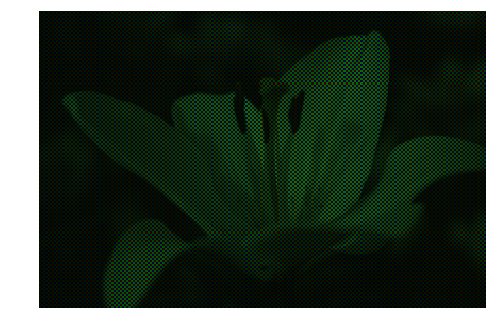

In [6]:
plt.figure(figsize=(8, 8))
# RAW画像表示。
imshow(raw_color)
# 軸非表示
plt.axis('off')
# 画像表示
plt.show()

さらに拡大してみます。

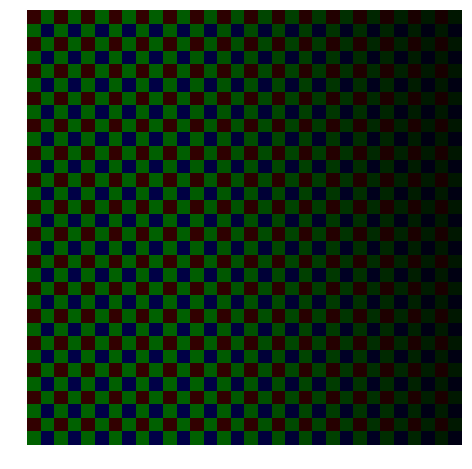

In [7]:
plt.figure(figsize=(8, 8))
# RAW画像の中から(1310, 2620)から32x32の領域を表示。
imshow(raw_color[1310:1342, 2620:2652])
# 軸非表示
plt.axis('off')
# 画像表示
plt.show()

これではなんだかよくわかりません。そういうわけでBayerをフルカラーのRGBに変換する処理が必用になるわけです。

## 簡易デモザイク処理

それではBayer配列からフルカラーの画像を作ってみましょう。

この処理はデモザイクと呼ばれることが多いです。本来デモザイクはカメラ画像処理プロセス（ISP)の肝になる部分で、画質のうち解像感や、偽色などの不快なアーティファクトなどを大きく左右します。 したがって手を抜くべきところではないのですが、今回は簡易処理なので、考えうる限りでもっとも簡単な処理を採用します。

その簡単な処理というのは、3色の情報を持つ最小単位の2x2のブロックから、1画素のみをとりだす、というものです。

![Bayer配列からRGB１画素への簡単な変換](https://github.com/moizumi99/camera_raw_processing/raw/master/fig2_2.png "Bayer配列からRGB１画素への簡単な変換")

結果として得られる画像サイズは1/4になりますが、もとが24Mもあるので、まだ6M残っていますので簡易処理としては十分でしょう。

なお、解像度低下をともなわないデモザイクアルゴリズムは応用編以降でとりあげます。


では、簡易デモザイク処理してみましょう。なお、2x2ピクセルの中に2画素ある緑は平均値をとります。

今回の処理では２つの緑画素は同じものとして扱うので、bayer配列を0, 1, 2で表しておきましょう。

In [8]:
bayer_pattern = raw.raw_pattern
# Bayer配列を0, 1, 2, 3から0, 1, 2表記に変更
bayer_pattern[bayer_pattern==3] = 1
# 表示して確認
print(bayer_pattern)

[[0 1]
 [1 2]]


では、2x2画素毎に平均をとってRGB画像を作ります。

In [9]:
# RGB画像を容易。サイズは縦横ともRAWデータの半分。
dms_img = np.zeros((h//2, w//2, 3))

# 各画素毎に処理.y, xはRAW画像での位置。
for y in range(0, h, 2):
    for x in range(0, w, 2):
        # bayer_pattern[0, 0]は2x2ブロックの左上の画素の色を示す
        dms_img[y // 2, x // 2, bayer_pattern[0, 0]] += raw_array[y + 0, x + 0]
        # bayer_pattern[0, 1]は2x2ブロックの右上の画素の色を示す
        dms_img[y // 2, x // 2, bayer_pattern[0, 1]] += raw_array[y + 0, x + 1]
        # bayer_pattern[1, 0]は2x2ブロックの左下の画素の色を示す
        dms_img[y // 2, x // 2, bayer_pattern[1, 0]] += raw_array[y + 1, x + 0]
        # bayer_pattern[1, 1]は2x2ブロックの右下の画素の色を示す
        dms_img[y // 2, x // 2, bayer_pattern[1, 1]] += raw_array[y + 1, x + 1]
        # 緑画素は２つあるので平均を取る
        dms_img[y // 2, x // 2, 1] /= 2

できあがった画像を見てみましょう。

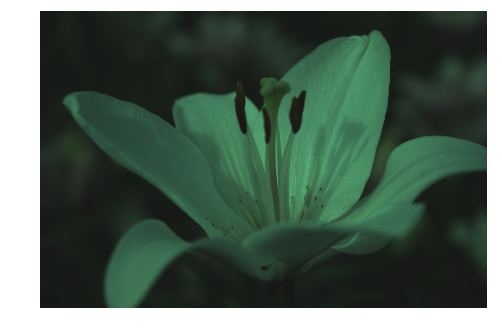

In [10]:
# 画像を0と1の間でノーマライズ
dms_img[dms_img < 0] = 0
dms_img = dms_img / dms_img.max()
# 表示
plt.figure(figsize=(8, 8))
imshow(dms_img)
plt.axis('off')
plt.show()

このようにRGBのフルカラー画像を作ることができました。

まだ色が正しくない、全体的に暗い、などの問題があります。次の節でこのあたりを修正していきます。

## 処理の高速化

上記のコードは、画像処理とコードの対応がわかりやすいように各画素ごとの処理をループを使って記述してあります。

これは処理の内容はわかりやすいのですが、numpyの高速性を十分に活用しておらず、かなり遅い処理になっています。このコードをnumpyの機能を利用して書き直すとこのようになります。

In [11]:
def simple_demosaic(raw_array, bayer_pattern):
    """
    簡易デモザイク処理を行う。

    Parameters
    ----------
    raw_array: numpy array
        入力BayerRAW画像データ
    bayer_pattern: int[2, 2]
        ベイヤーパターン。0:赤、1:緑、2:青、3:緑。

    Returns

    -------
    dms_img: numpy array
        出力RGB画像。サイズは入力の縦横共に1/2。
    """
    height, width = raw_array.shape
    dms_img = np.zeros((height//2, width//2, 3))
    bayer_pattern[bayer_pattern == 3] = 1
    dms_img[:, :, bayer_pattern[0, 0]] = raw_array[0::2, 0::2]
    dms_img[:, :, bayer_pattern[0, 1]] += raw_array[0::2, 1::2]
    dms_img[:, :, bayer_pattern[1, 0]] += raw_array[1::2, 0::2]
    dms_img[:, :, bayer_pattern[1, 1]] += raw_array[1::2, 1::2]
    dms_img[:, :, 1] /= 2
    return dms_img

処理の内容としては最初のループを使ったコードと同じですが、速度は格段に上がっています。

同じ画像になったか確認してみましょう。

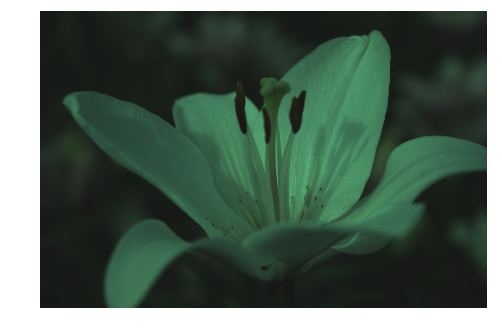

In [12]:
dms_img = simple_demosaic(raw_array, raw.raw_pattern)

# 画像を0と1の間でノーマライズ
dms_img[dms_img < 0] = 0
dms_img = dms_img / dms_img.max()
# 表示
plt.figure(figsize=(8, 8))
imshow(dms_img)
plt.axis('off')
plt.show()

同様の画像が出力されたようです。

この`simple_demosaic()`関数を含んだモジュールが`raw_process.py`として[githubにアップロード](https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py)されています。
使用する場合は、

`!wget https://raw.githubusercontent.com/moizumi99/raw_process/master/raw_process.py`

としてダウンロードした後、

`from raw_process import simple_demosaic`

としてインポートしてください。

## この節のまとめ

RAW画像に対して簡易デモザイク処理を行いました。